In [ ]:
import pandas as pd

nifty100_df = pd.read_csv('nifty100.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty100_df.Symbol.tolist()]

In [ ]:
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, "1D", start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data = load_stock_data(file_paths, data_path, "1D")

In [9]:
ohlc_dict = {
    'Open': 'first',
    'Close': 'last',
    'exit_time': 'last'
}

df = pd.concat(loaded_data, names=["Stock", "Date"]).reset_index()
# df = df[df.Date > '2024-07-01'].reset_index(drop=True)
df['exit_time'] = df.Date.shift(-1)
# df = df.set_index(['Stock', 'Date']).sort_index()
df = df.groupby('Stock').resample('MS', on='Date').agg(ohlc_dict)

In [10]:
df['entry_price'] = df.groupby('Stock')['Open'].shift(-1)
df['exit_price'] = df.groupby('Stock')['Close'].shift(-1)
df['returns'] = df.groupby('Stock')['Close'].diff()
df['returns_perc'] = df.groupby('Stock')['Close'].pct_change()
df['next_month_returns'] = df.groupby('Stock')['returns'].shift(-1)
df['next_month_returns_perc'] = df.groupby('Stock')['returns_perc'].shift(-1)

In [11]:
from sklearn.linear_model import LinearRegression

def rolling_monthly_slope_fitness(df, window=12):
    df = df.sort_values(['Stock', 'Date'])
    results = []
    for stock, group in df.groupby('Stock'):
        group = group.reset_index(drop=True)
        group['Date_ordinal'] = group['Date'].map(lambda x: x.toordinal())
        for i in range(len(group) - window + 1):
            window_df = group.iloc[i:i+window]
            X = window_df['Date_ordinal'].values.reshape(-1, 1)
            y = window_df['Close'].values
            model = LinearRegression().fit(X, y)
            slope = model.coef_[0]
            fitness = model.score(X, y)  # R² score
            results.append({
                'Stock': stock,
                'Start_Date': window_df['Date'].iloc[0],
                'End_Date': window_df['Date'].iloc[-1],
                f'Slope_{window}m': slope,
                f'Fitness_{window}m': fitness
            })
    return pd.DataFrame(results).set_index(['Stock', 'End_Date'])

# Usage:
slope_12m = rolling_monthly_slope_fitness(df.reset_index(), window=12)
slope_12m['score'] = slope_12m['Slope_12m'] * slope_12m['Fitness_12m']

start_date = slope_12m.index.get_level_values('End_Date')[0]

slope_6m = rolling_monthly_slope_fitness(df.reset_index(), window=6)
slope_6m['score'] = slope_6m['Slope_6m'] * slope_6m['Fitness_6m']
slope_6m = slope_6m[slope_6m.index.get_level_values('End_Date') >= start_date]

slope_3m = rolling_monthly_slope_fitness(df.reset_index(), window=3)
slope_3m['score'] = slope_3m['Slope_3m'] * slope_3m['Fitness_3m']
slope_3m = slope_3m[slope_3m.index.get_level_values('End_Date') >= start_date]

In [12]:
def top_n(_df, n, mask=None):
    dfs = []
    for idx, row in _df.groupby('End_Date'):
        date_mask = []
        if mask is not None:
            date_mask = mask.loc[idx].index.tolist()
            dfs.append(row.loc[date_mask].score.nlargest(n))
        else:
            dfs.append(row.score.nlargest(n))
    return pd.concat(dfs)

top_50 = top_n(slope_12m, 50)
top_30 = top_n(slope_6m, 30, top_50.swaplevel('Stock', 'End_Date').sort_index())
top_10 = top_n(slope_3m, 10, top_30.swaplevel('Stock', 'End_Date').sort_index())
top_10 = top_10.swaplevel('Stock', 'End_Date').sort_index()

                      Metrics                    Values
0                      Period  2015-12-01 to 2025-08-01
1            Starting capital                    500000
2               Final capital                 755838.37
3                Total Trades                      1084
4                     Winners                       574
5                      Losers                       510
6               Profit factor                  1.064846
7       Active Position Count                         0
8   Max holding period (days)                        33
9   Avg holding period (days)                        31
10               Win Rate (%)                  52.95203
11               Total Profit                 255838.37
12            Total Brokerage                       0.0
13                  Total Tax                 657341.03
14                  Total MTF                 606175.94
15                   CAGR (%)                  4.367049
16          Max Drawdown (%):                 39

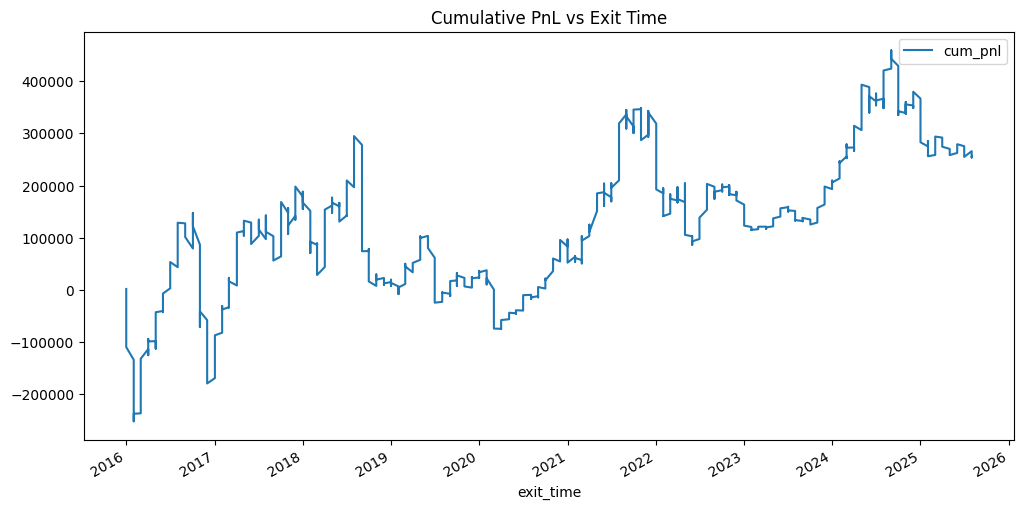

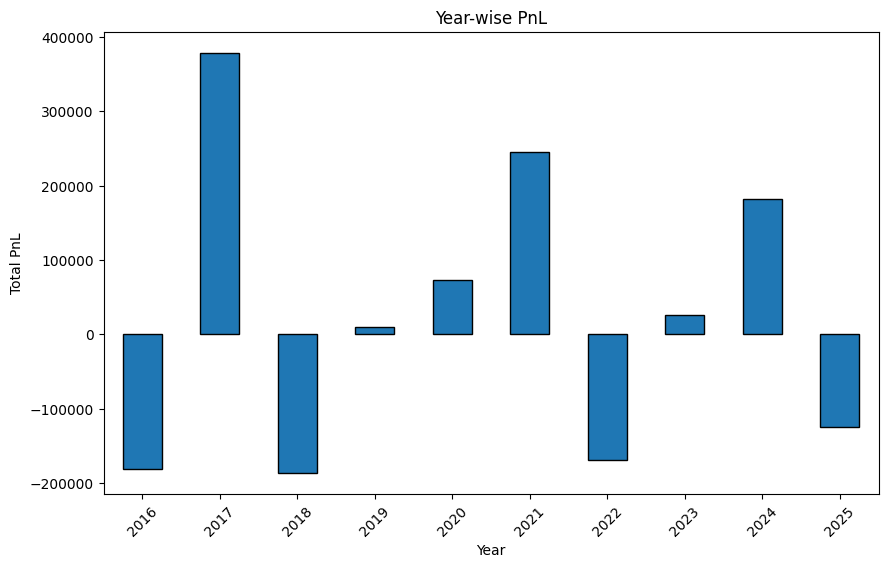

In [13]:
from lib import Bank, PositionManager, generate_tearsheet, show_equity_curve

initial_capital = 500000
leverage = 5


def backtest(pm: PositionManager):
    data = df[df.index.get_level_values(1) >= start_date].dropna(subset=['entry_price', 'exit_price'])
    for idx, group in data.groupby('Date'):
        date = idx
        selected_stocks = top_10.loc[date].index.tolist()
        capital_split = pm.bank.total_capital() / len(selected_stocks)
        for s in selected_stocks:
            d = group.loc[(s, date)]
            capital = d['entry_price'] * round(capital_split/d['entry_price'])
            pm.new_position(s, date, d['entry_price'], capital)
        
        for s in selected_stocks:
            if pm.get_position(s) is not None:
                d = group.loc[(s, date)]
                pm.close_position(s, d['exit_time'], d['exit_price'])

    return generate_tearsheet(initial_capital, pm)

if __name__ == "__main__":
    bank = Bank(initial_capital)
    pm = PositionManager(bank, leverage=leverage)
    tearsheet, trades = backtest(pm)
    print(pd.DataFrame({
        "Metrics": tearsheet.keys(),
        "Values": tearsheet.values(),
    }))
    show_equity_curve(trades)